
<img src="notebook_images/vgg_profiling.png" alt="VGG Profiling Image" style="width: 400px;float: right;margin: 10pt"/>

# Deep Data Profiler(DDP)

The package, Deep Data Profiler, was inspired by the work of Qiu, Yuxian, et al. in there paper "Adversarial Defense Through Network Profiling Based Path Extraction." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2019

DDP characterizes both the data and the model, pointing to the most influential neurons and weights used for classification, and going beyond a summary output by incorporating the inter-relationships between neurons and weights in the profiled layers. DDP is currently implemented for Pytorch modules: 
- torch.nn.Linear,
- torch.nn.MaxPool2d,
- torch.nn.AdaptiveAvgPool2d,
- torch.nn.Conv2d

**Important Terms** 
- Layers - collections of modules across the model. We group weighted modules with their activations and treat these as a single layer. Pooling modules are given their own layers as they effect the indices of contributing neurons.
- Neuron - the index of an input or output tensor for each layer, we identify the most influential neurons
- Synapse - a tuple of input and output neurons (and weight indices where appropriate) within a layer
- Profile instance - the critical set of neurons and synapses (up to a threshold value) that leads to a final predicted class
- Threshold - the percentage of a neuron value required from its contributing neurons
- Class Profile - the union of profile instances for inputs from the same class
- Jaccard metrics 
    - Computes similarity between profiles
    - Can cluster sets of profiles


## Import libraries and data

In [1]:
import sys
sys.path.append('..')
import os,json,pickle
import deep_data_profiler as ddp
import torch
from torchvision import transforms
import torchvision.models.vgg as vgg
import numpy as np
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import defaultdict,Counter
import warnings, concurrent.futures
warnings.filterwarnings('ignore')

In [2]:
## helper method for viewing images:
def pilimread(impath):
    '''
    Read image from file into a normalized np.array
    '''
    im = Image.open(impath)
    return np.array(im)/255.0

In [3]:
## To ensure reproducibility we set the pytorch seed. This only works if the versioning of libraries is held
## constant
torch.manual_seed(0)
## We will also specify the device. The profiling code will run on cpu or cuda.
device=torch.device('cpu')

In [4]:
## For this tutorial we use 15 samples from imagenet, 
imagepaths = pickle.load(open('imagenet_data/imagepaths.p','rb'))
## We stored the original images here for reference here
datadir = "imagenet_data/images"


In [5]:
imagepaths

{'eagles': {0: 'n01614925/ILSVRC2012_val_00002031.JPEG',
  1: 'n01614925/ILSVRC2012_val_00048960.JPEG',
  2: 'n01614925/ILSVRC2012_val_00040608.JPEG',
  3: 'n01614925/ILSVRC2012_val_00046632.JPEG',
  4: 'n01614925/ILSVRC2012_val_00014007.JPEG'},
 'vultures': {0: 'n01616318/ILSVRC2012_val_00040205.JPEG',
  1: 'n01616318/ILSVRC2012_val_00002168.JPEG',
  2: 'n01616318/ILSVRC2012_val_00032889.JPEG',
  3: 'n01616318/ILSVRC2012_val_00035953.JPEG',
  4: 'n01616318/ILSVRC2012_val_00018092.JPEG'},
 'goldfish': {0: 'n01443537/ILSVRC2012_val_00049585.JPEG',
  1: 'n01443537/ILSVRC2012_val_00018075.JPEG',
  2: 'n01443537/ILSVRC2012_val_00005870.JPEG',
  3: 'n01443537/ILSVRC2012_val_00047561.JPEG',
  4: 'n01443537/ILSVRC2012_val_00032235.JPEG'}}

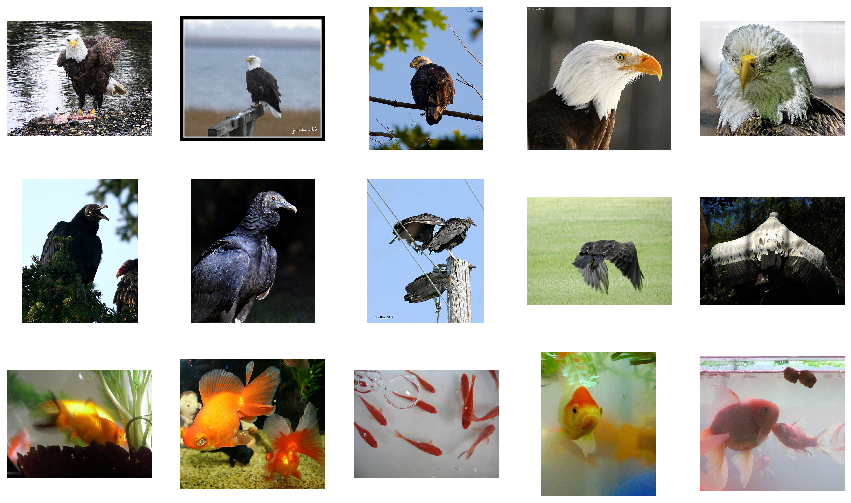

In [6]:
## View the sample images, rows 1 and 2 are more similar than row 3
fig,ax = plt.subplots(3,5,figsize=(15,9))
classes = ['eagles','vultures','goldfish']
for i in range(15):
    ax[i//5][i%5].axis('off')
    ax[i//5][i%5].imshow(pilimread(f'{datadir}/{imagepaths[classes[i//5]][i%5]}'))

## What is in a profile?

Let's look at a profile of a single image in the eagles class. We use the profile to find the largest contributors among the neurons and weights that lead to the final classification. Each profile contains python dictionaries of neuron_counts, synapse_counts, and synapse_weights, listing the significant contributors for the layers profiled, starting with the final layer (layer=1) and working backwards.
Each profile has aggregation metrics of total and size. Profiles may be added together to form a new profile or added in place.

The neuron counts is a collections.Counter object, which indicates the number of significant synapses a neuron participates in on a single layer. The synapse counts correspond to the counts of connections between input and output neurons through each layer. The synapse weights returns a set of weighted graph edges representing the weighted connections between input and output neurons.

In [7]:
eagle_profile = pickle.load(open('imagenet_data/eagle-profile.p','rb'))

In [8]:
eagle_profile

### Neuron Counts:
**Note that each layer points at a counter object listing the contributing neurons and the number of times each contributes within the layer. The first layer has only one contributing neuron as it corresponds to the index of the deciding logit. As you move along the layers the number of contributing neurons grows as we add the contributing neurons of contributing neurons. In this example we used a threshold of 0.1, meaning for each contributing neuron $n$, starting with the single in the 0 layer, we searched for the smallest set of neurons $\{n_\alpha\}$ in the next layer which would contribute to $10\%$ of the value of the neuron at $n$.**

In [9]:
eagle_profile.neuron_counts.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

In [10]:
## The eagle class corresponds to the index of 22 in the final logit tensor.
eagle_profile.neuron_counts[0]

Counter({(22,): 1})

In [11]:
print(eagle_profile.neuron_counts[1])

Counter({(3691,): 1, (271,): 1, (2661,): 1, (343,): 1, (1491,): 1, (3414,): 1, (391,): 1, (1366,): 1, (2002,): 1, (3481,): 1, (988,): 1})


In [12]:
## As more and more neurons are added in each layer the number of contributing neurons 
## in subsequent layers increases
print([len(eagle_profile.neuron_counts[k]) for k in eagle_profile.neuron_counts.keys()])

[1, 11, 24, 39, 39, 39, 56, 70, 81, 81, 111, 151, 198, 198, 284, 417, 447, 447, 628, 588, 588, 675, 622]


### Synapse Counts and Weights
**The synapse counts are keyed by input,output and weight indices(where appropriate) index tuples. In layer 1 all input neurons connect to the single output neuron from layer 0.**

In [13]:
## The synapses indicate what input neurons in the layer contribute to each output neuron
eagle_profile.synapse_counts[1]

Counter({((3691,), (22,)): 1,
         ((271,), (22,)): 1,
         ((2661,), (22,)): 1,
         ((343,), (22,)): 1,
         ((1491,), (22,)): 1,
         ((3414,), (22,)): 1,
         ((391,), (22,)): 1,
         ((1366,), (22,)): 1,
         ((2002,), (22,)): 1,
         ((3481,), (22,)): 1,
         ((988,), (22,)): 1})

In [14]:
## The 6th layer is a convolutional layer. The 3 tuples indicate input index, output index, and filter index. 
## The first output index indicates which filter was used.
{k:eagle_profile.synapse_counts[6][k] for k in list(eagle_profile.synapse_counts[6].keys())[:5]}

{((127, 9, 7), (36, 8, 8), (127, 2, 0)): 1,
 ((349, 9, 8), (370, 10, 8), (349, 0, 1)): 1,
 ((127, 9, 8), (370, 10, 8), (127, 0, 1)): 1,
 ((374, 3, 9), (443, 3, 10), (374, 1, 0)): 1,
 ((86, 3, 10), (443, 3, 10), (86, 1, 1)): 1}

In [15]:
## The synapse weights give a set of weighted edges for a bipartite graph.
eagle_profile.synapse_weights[1]

{((271,), (22,), (0.011154,)),
 ((343,), (22,), (0.010331,)),
 ((391,), (22,), (0.008451,)),
 ((988,), (22,), (0.008147,)),
 ((1366,), (22,), (0.00844,)),
 ((1491,), (22,), (0.009841,)),
 ((2002,), (22,), (0.008222,)),
 ((2661,), (22,), (0.011018,)),
 ((3414,), (22,), (0.009652,)),
 ((3481,), (22,), (0.008155,)),
 ((3691,), (22,), (0.011191,))}

In [16]:
## The sum of the weights is the proportion of the output neuron's value that the input neurons provide
## We had set the threshold for .10
sum([w[0] for _,_,w in eagle_profile.synapse_weights[1]])

0.104602

## How do we compute a profile?

Profiling requires a pretrained model and data that mirrors the training data. In this example the model is the pretrained
PyTorch VGG16 model. We create a profiler for the data by instantiating the class ddp.TorchProfiler with the 
pretrained model.

We have preprocessed the images above into torch tensors suitable as input for the VGG16 model. To create a 
profile for these images we use the ddp.TorchProfiler.create_profile() method on each image.

### First we instantiate the PyTorch VGG-16 model and its DDP Profiler, profiler, with a threshold.  The model is wrapped as a TorchHook model, which allows us to specify the layers we wish to profile.

In [17]:
threshold=0.1 ## this makes the data manageable for the example
model = vgg.vgg16(pretrained=True).eval()
profiler = ddp.TorchProfiler(model, threshold=threshold)
profiler.model

In [18]:
## We load the vectorized inputs we wish to profile 
timages = pickle.load(open('imagenet_data/timages.p','rb'))
timages.keys(),len(timages['eagles'])

(dict_keys(['eagles', 'vultures', 'goldfish']), 5)

### Next we decide which layers we wish to profile. First let's take a look at the available modules.

In [19]:
profiler.model.available_modules()

OrderedDict([('features.0',
              Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('features.1', ReLU(inplace=True)),
             ('features.2',
              Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('features.3', ReLU(inplace=True)),
             ('features.4',
              MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
             ('features.5',
              Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('features.6', ReLU(inplace=True)),
             ('features.7',
              Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('features.8', ReLU(inplace=True)),
             ('features.9',
              MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
             ('features.10',
              Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
           

### For profiling, layers are weighted modules or pooling modules. For this example we will profile the last 6 layers. We construct a layer dictionary to pass to the profiler.
Note: The layers are keyed starting with 1 and work backwards. The final layer is used only for providing inputs for the final requested layer. In the example we requested 6 layers so there are 7 layers listed in the layerdict.

In [20]:
## note the helper function referenced in each layer start with _contrib and 
## refer to the type of Pytorch layer being profiled
layerdict = profiler.create_layers(6);layerdict

OrderedDict([(1, [['classifier.6'], '_contrib_linear']),
             (2, [['classifier.3', 'classifier.4'], '_contrib_linear']),
             (3, [['classifier.0', 'classifier.1'], '_contrib_linear']),
             (4, [['avgpool'], '_contrib_adaptive_avg_pool2d']),
             (5, [['features.30'], '_contrib_max2d']),
             (6, [['features.28', 'features.29'], '_contrib_conv2d']),
             (7, [['features.27'], 0])])

### Finally we instantiate the 15 profiles, running through the 3 classes
**Notes**  
- It takes approximately 4 minutes to run 6 layers of profiles on the 15 images without parallelization.
- With parallel == True it takes about a minute depending on your operating system.
- To run the code change the cell format below from Raw NBConvert to Code.
- We pickled the resulting profiles for 6 layers on the 15 images and stored them in `imagenet_data/profiles-6layers.p`

In [21]:
tprofiles = pickle.load(open('imagenet_data/profiles-6layers.p','rb'))
tprofiles

defaultdict(dict,
            {'eagles': {0: <deep_data_profiler.classes.profile.Profile at 0x7fb330a26278>,
              1: <deep_data_profiler.classes.profile.Profile at 0x7fb330a74be0>,
              2: <deep_data_profiler.classes.profile.Profile at 0x7fb330a96588>,
              3: <deep_data_profiler.classes.profile.Profile at 0x7fb330c80cf8>,
              4: <deep_data_profiler.classes.profile.Profile at 0x7fb2f04280b8>},
             'vultures': {0: <deep_data_profiler.classes.profile.Profile at 0x7fb2f043a5f8>,
              1: <deep_data_profiler.classes.profile.Profile at 0x7fb330a2ec18>,
              2: <deep_data_profiler.classes.profile.Profile at 0x7fb330a652b0>,
              3: <deep_data_profiler.classes.profile.Profile at 0x7fb330ce6588>,
              4: <deep_data_profiler.classes.profile.Profile at 0x7fb330dd1b00>},
             'goldfish': {0: <deep_data_profiler.classes.profile.Profile at 0x7fb330df1b38>,
              1: <deep_data_profiler.classes.profile.Pr

## Profiles instances

In [22]:
tprofiles['eagles']

{0: <deep_data_profiler.classes.profile.Profile at 0x7fb330a26278>,
 1: <deep_data_profiler.classes.profile.Profile at 0x7fb330a74be0>,
 2: <deep_data_profiler.classes.profile.Profile at 0x7fb330a96588>,
 3: <deep_data_profiler.classes.profile.Profile at 0x7fb330c80cf8>,
 4: <deep_data_profiler.classes.profile.Profile at 0x7fb2f04280b8>}

In [23]:
print(tprofiles['eagles'][0].synapse_weights.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6])


## Class Profiles

Profiles are additive so we aggregate the profiles belonging to inputs in the same class to obtain class profiles.  


In [24]:
class_profiles = dict()
for cls in classes:
    class_profiles[cls] = ddp.Profile()
    for p in tprofiles[cls]:
        class_profiles[cls] += tprofiles[cls][p]   

In [25]:
class_profiles['eagles'].neuron_counts[0]

Counter({(22,): 5})


## Profiling metrics

The jaccard_simple metric on sets is a value between 0 and 1 that compares two sets by the size of their intersection and the size of their union. If the sets are identical the value is 1. If disjoint the value is 0.

\begin{align}
\text{jaccard_simple}(A,B) = \frac{|A \cap B|}{|A \cup B|}
\end{align}

We have three metrics which use jaccard_simple:
- $\text{jaccard}(P_A,P_B))$   
    compares the size of the sets of synapses(or nodes) found significant across all layers in the profiles for $P_A$ and $P_B$.
- $\text{avg_jaccard}(P_A,P_B)$   
    computes the average of the jaccard_simple metric comparing the significant synapses(or nodes) found in each layer
- $\text{instance_jaccard}(P_A,P_B))$   
    computes the proportion of the set of synapses(or nodes) found significant across all layers in $P_A$ that also belong to $P_B$

### Jaccard and avg_jaccard metrics compare similar sized profiles - image to image or class to class
We note that the jaccard and avg_jaccard metrics are similar on 6layers. They diverge on all layer as can be seen at the end of this tutorial.

**Note below that the jaccard metrics on eagles and vultures is higher than between eagles and goldfish or vultures and goldfish.**

In [26]:
print(f"jaccard sim = {ddp.jaccard(class_profiles['eagles'],class_profiles['vultures'])}")
print(f"avg_jaccard sim = {ddp.avg_jaccard(class_profiles['eagles'],class_profiles['vultures'])}")


jaccard sim = 0.014397367338543809
avg_jaccard sim = 0.01805188568062286


In [27]:
print(f"jaccard sim = {ddp.jaccard(class_profiles['eagles'],class_profiles['goldfish'])}")
print(f"avg_jaccard sim = {ddp.avg_jaccard(class_profiles['eagles'],class_profiles['goldfish'])}")

jaccard sim = 0.007037297677691766
avg_jaccard sim = 0.007773377817215324


In [28]:
print(f"jaccard sim = {ddp.jaccard(class_profiles['vultures'],class_profiles['goldfish'])}")
print(f"avg_jaccard sim = {ddp.avg_jaccard(class_profiles['vultures'],class_profiles['goldfish'])}")

jaccard sim = 0.00418702023726448
avg_jaccard sim = 0.0049308492942350644


**Heatmap across classes: By taking the log of the similarity value we can see the differences more clearly. The more similar the profiles, the darker the hue.**

In [29]:
## View the sample image, rows 1 and 2 are more similar than row 3
classes = ['eagles','vultures','goldfish']
cjsim = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        cjsim[i][j] = np.log(ddp.avg_jaccard(class_profiles[classes[i]],class_profiles[classes[j]]))

In [30]:
# plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Blues).set_array(cjsim)


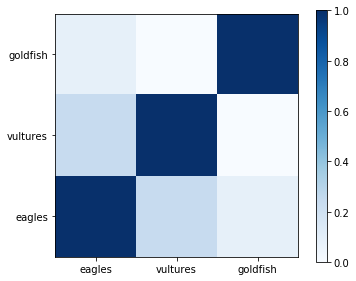

In [31]:
# vmin,vmax = np.min(cjsim.flatten()),np.max(cjsim.flatten())
cmap=plt.cm.Blues

fig,ax = plt.subplots(1,1,figsize=(5,5))
im = plt.imshow(cjsim, interpolation='nearest', cmap=cmap)

norm = mpl.colors.Normalize(vmin=0, vmax =1)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(cjsim.flatten())

# fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
plt.ylim(-.5,2.5)
plt.yticks(np.arange(3),['eagles','vultures','goldfish'])
plt.xticks(np.arange(3),['eagles','vultures','goldfish'])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])

fig.colorbar(sm, cax=cbar_ax);

**Here we illustrate that on the instance level, images in the same class have more similar profiles than images in other classes**

In [32]:
for i in range(0,5):
    print(ddp.avg_jaccard(tprofiles['eagles'][0],tprofiles['eagles'][i]))

1.0
0.1088380111276233
0.04498477744942788
0.045238095238095244
0.10796850830549387


In [33]:
for i in range(0,5):
    print(ddp.avg_jaccard(tprofiles['eagles'][0],tprofiles['vultures'][i]))

0.0
0.005791677804508598
0.021916737709576584
0.009057609057609058
0.012716515897553342


In [34]:
for i in range(0,5):
    print(ddp.avg_jaccard(tprofiles['eagles'][0],tprofiles['goldfish'][i]))

0.0
0.008775813105457053
0.0
0.0
0.0022522522522522522


**Heatmap across instances: The heatmap (using log scale) illustrates this across all 15 images.**

In [35]:
## View the sample image, rows 1 and 2 are more similar than row 3
# fig,ax = plt.subplots(3,5,figsize=(15,9))
classes = ['eagles','vultures','goldfish']
jsim = np.zeros((15,15))
jsim1 = np.zeros((15,15))
jsim2 = np.zeros((15,15))
for i in range(15):
    for j in range(15):
        jsim1[i][j] = np.log(ddp.avg_jaccard(tprofiles[classes[i//5]][i%5],tprofiles[classes[j//5]][j%5]))
        jsim2[i][j] = np.log(ddp.jaccard(tprofiles[classes[i//5]][i%5],tprofiles[classes[j//5]][j%5]))

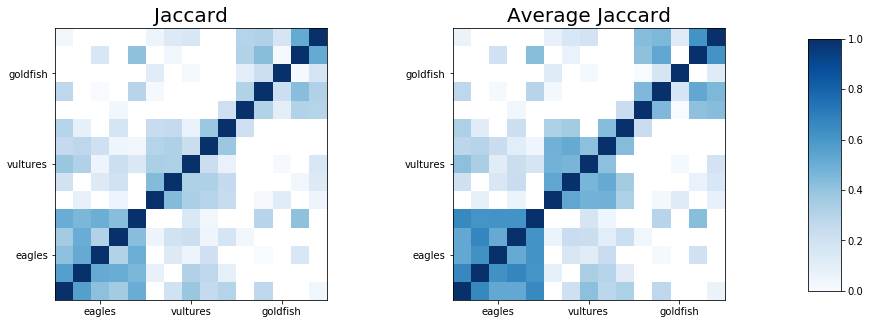

In [36]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
cmap=plt.cm.Blues
for idx in range(2):
    ax[idx].set_ylim(-.5,14.5)
    ax[idx].set_yticks(np.arange(2,14,5))
    ax[idx].set_yticklabels(['eagles','vultures','goldfish'])
    ax[idx].set_xticks(np.arange(2,14,5),)
    ax[idx].set_xticklabels(['eagles','vultures','goldfish'])

ax[0].imshow(jsim2, interpolation='nearest', cmap=cmap)
ax[0].set_title('Jaccard',fontsize=20)
ax[1].imshow(jsim1, interpolation='nearest', cmap=cmap)
ax[1].set_title('Average Jaccard',fontsize=20)

norm = mpl.colors.Normalize(vmin=0, vmax =1)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(jsim1.flatten())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(sm, cax=cbar_ax);

### Instance Jaccard compares image to class
**While the instance jaccard for our examples against their own classes must be one, we can look at the instance jaccard of an example against the other classes to study similarity between classes.**

In [37]:
[ddp.instance_jaccard(tprofiles['eagles'][i],class_profiles['vultures']) for i in range(5)]

[0.07142857142857142,
 0.04950495049504951,
 0.02127659574468085,
 0.029304029304029304,
 0.010033444816053512]

In [38]:
[ddp.instance_jaccard(tprofiles['eagles'][i],class_profiles['goldfish']) for i in range(5)]

[0.02142857142857143,
 0.0,
 0.010638297872340425,
 0.003663003663003663,
 0.05016722408026756]

In [39]:
[ddp.instance_jaccard(tprofiles['vultures'][i],class_profiles['eagles']) for i in range(5)]

[0.00847457627118644,
 0.023880597014925373,
 0.058577405857740586,
 0.026217228464419477,
 0.028708133971291867]

In [40]:
[ddp.instance_jaccard(tprofiles['vultures'][i],class_profiles['goldfish']) for i in range(5)]

[0.01694915254237288,
 0.005970149253731343,
 0.012552301255230125,
 0.0,
 0.014354066985645933]

In [41]:
[ddp.instance_jaccard(tprofiles['goldfish'][i],class_profiles['eagles']) for i in range(5)]

[0.003105590062111801,
 0.02576112412177986,
 0.0,
 0.04700854700854701,
 0.0035460992907801418]

In [42]:
[ddp.instance_jaccard(tprofiles['goldfish'][i],class_profiles['vultures']) for i in range(5)]

[0.009316770186335404,
 0.00234192037470726,
 0.0069124423963133645,
 0.004273504273504274,
 0.01773049645390071]

**Differences in Instance Jaccard for single images against class profiles:**

In [43]:
classes = ['eagles','vultures','goldfish']
sijsim = np.zeros((3,15))
for i in range(15):
    for j in range(3):
        sijsim[j][i] = np.log(ddp.instance_jaccard(tprofiles[classes[i//5]][i%5],class_profiles[classes[j]]))

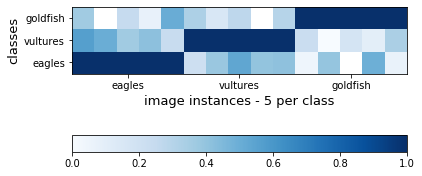

In [44]:
cmap=plt.cm.Blues
plt.imshow(sijsim, interpolation='nearest', cmap=cmap)
plt.ylim(-.5,2.5)
plt.yticks(np.arange(3),['eagles','vultures','goldfish'])
plt.xticks(np.arange(2,14,5),['eagles','vultures','goldfish'])
plt.xlabel('image instances - 5 per class\n\n',fontsize=13)
plt.ylabel('classes',fontsize=13);

norm = mpl.colors.Normalize(vmin=0, vmax =1)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(sijsim.flatten())
c=plt.colorbar(sm, orientation='horizontal');

cax = c.ax
pos1 = cax.get_position()
yshift = .1 
pos2 = [pos1.x0, pos1.y0 - yshift, pos1.width, pos1.height]
cax.set_position(pos2)


## All Layer profiles
The greatest distinction between classes is seen in the average jaccard when all layers are used.
 
(We reproduce the code and results for you to generate your own profiles. Change the cell type below to code to generate your own profiles.)


CPU times: user 3min 42s, sys: 26.5 s, total: 4min 8s     
Wall time: 6min 26s

In [45]:
aprofiles = pickle.load(open('imagenet_data/profiles-alllayers.p','rb'))

aclass_profiles = dict()
for cls in classes:
    aclass_profiles[cls] = ddp.Profile()
    for p in aprofiles[cls]:
        aclass_profiles[cls] += aprofiles[cls][p] 

# Average Jaccard
ajsim = np.zeros((15,15))
for i in range(15):
    for j in range(15):
        ajsim[i][j] = np.log(ddp.avg_jaccard(aprofiles[classes[i//5]][i%5],aprofiles[classes[j//5]][j%5]))

# Jaccard
rjsim = np.zeros((15,15))
for i in range(15):
    for j in range(15):
        rjsim[i][j] = np.log(ddp.jaccard(aprofiles[classes[i//5]][i%5],aprofiles[classes[j//5]][j%5]))

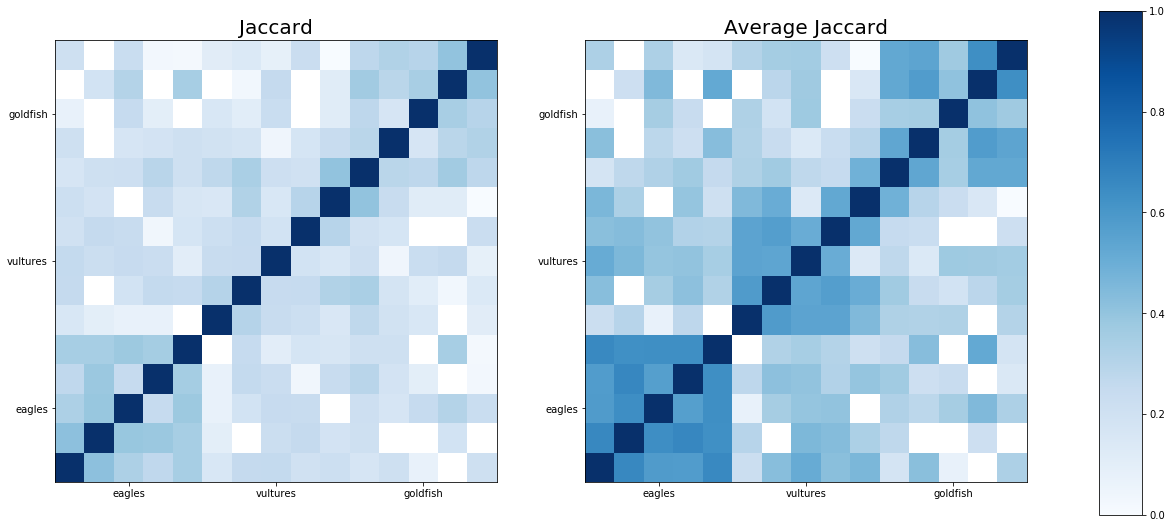

In [46]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
cmap=plt.cm.Blues
for idx in range(2):
    ax[idx].set_ylim(-.5,14.5)
    ax[idx].set_yticks(np.arange(2,14,5))
    ax[idx].set_yticklabels(['eagles','vultures','goldfish'])
    ax[idx].set_xticks(np.arange(2,14,5),)
    ax[idx].set_xticklabels(['eagles','vultures','goldfish'])

ax[0].imshow(rjsim, interpolation='nearest', cmap=cmap)
ax[0].set_title('Jaccard',fontsize=20)
ax[1].imshow(ajsim, interpolation='nearest', cmap=cmap)
ax[1].set_title('Average Jaccard',fontsize=20)

norm = mpl.colors.Normalize(vmin=0, vmax =1)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(ajsim.flatten())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(sm, cax=cbar_ax);